In [1]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim
from math import exp

In [81]:
# initialize parameters
#dx is the step size for test set

global k, dx, beta 
k, dx, beta = 10, .001, 1

In [111]:
def f(x):
    if x< 0.5 :
        return 8*k*(3*x-1)
    else :
        return 4*k*(k+1)
    
def g(x):
    return torch.tensor([0.], requires_grad=True)

def u_exact(x):
    if x< 0.5 :
        return 4*k*x**2*(1-x)
    else :
        return (2*(k+1)*x-1)*(1-x)

def sigma_exact(x):
    if x< 0.5 :
        return 12*k*x**2-8*k*x
    else :
        return 4*k*(k+1)*x - 2 *k*k - 3*k

sq = lambda x: x ** 2
vsq = np.vectorize(sq)

In [118]:
# compute H1 norm of true u and sigma
L = 0.
R = 1.
test_set1 =  np.arange(L, R/2, dx)
test_set2 =  np.arange(R/2, R, dx)
u1 = np.vectorize(u_exact)(test_set1)
ud1 = -np.vectorize(sigma_exact)(test_set1)
u2 = np.vectorize(u_exact)(test_set2)
ud2 = -np.vectorize(sigma_exact)(test_set2)
u_h1 = np.sum(dx*(vsq(u1) + vsq(ud1)+ k* vsq(u2) + k * vsq(ud2) ))
u_l2 = np.sum(dx*vsq(u1)+ dx*vsq(u2) )

sigma1 = np.vectorize(sigma_exact)(test_set1)
sigmad1 = np.vectorize(f)(test_set1)
sigma2 = np.vectorize(sigma_exact)(test_set2)
sigmad2 = np.vectorize(f)(test_set2)

sigma_h1 = np.sum(dx*(vsq(sigma1) + vsq(sigmad1) + k* vsq(sigma2) + k* vsq(sigmad2)))
sigma_l2 = np.sum(dx*vsq(sigma1) + dx*vsq(sigma2) )

print('u: H1 norm square: %.6f, L2 norm square: %.6f ' %(u_h1, u_l2))
print('sigma: H1 norm square: %.6f, L2 norm square: %.6f ' %(sigma_h1, sigma_l2))

u: H1 norm square: 70076.634481, L2 norm square: 10.414888 
sigma: H1 norm square: 1038805.849400, L2 norm square: 7051.299400 


In [84]:
class MuSigmaPde(nn.Module):
    def __init__(self, dimension, mesh = 32, neuron = 24):
        super(MuSigmaPde, self).__init__()

        self.xdim = dimension
        # Layer 1
        self.fc1mu = nn.Linear(dimension, mesh)
        self.fc1sig = nn.Linear(dimension, mesh)
        # Layer 2
        self.fc2mu = nn.Linear(mesh, neuron)
        self.fc2sig = nn.Linear(mesh, neuron)
        # Layer 3
        self.fc3mu = nn.Linear(neuron, neuron)
        self.fc3sig = nn.Linear(neuron, neuron)
        # Layer 4
        self.fc4mu = nn.Linear(neuron, 1)
        self.fc4sig = nn.Linear(neuron, dimension)

    def forward(self, x):   #Activation Function Sigmoid
        assert(len(x.shape) == 1 and x.shape[0] == self.xdim)
        mu =  torch.sigmoid(self.fc2mu(torch.sigmoid(self.fc1mu(x))))
        sig =  torch.sigmoid(self.fc2sig(torch.sigmoid(self.fc1sig(x))))
        mu =  self.fc4mu(torch.sigmoid(self.fc3mu(mu)))
        sig = self.fc4sig(torch.sigmoid(self.fc3sig(sig)))
        return mu, sig
      
    def net_grad(self, x):
        mu_center, sigma_center = self.forward(x)
        mu_forward, sigma_forward = self.forward(x - 0.5*dx)

        mu_grad_forward = (mu_center - mu_forward)/(0.5*dx)
        sigma_grad_forward = (sigma_center - sigma_forward)/(0.5*dx)
    
        return mu_grad_forward, sigma_grad_forward
    
    def loss_function_bulk(self, x):    #FOSLS
        mu, sigma = self.forward(x)
        mu_grad, sigma_grad = self.net_grad(x)
        if x< 0.5:
            LSE = torch.sum((mu_grad + sigma)**2) + (sigma_grad - f(x))**2 
        else:
            LSE = torch.sum((mu_grad * k**(0.5) + sigma* k**(-0.5))**2) + (sigma_grad - f(x))**2
        return LSE 

    def loss_function_surf(self, x):
        mu, sigma = self.forward(x)
        # Boundary condition penalty
        BCP = beta * (mu - g(x))**2
        return BCP

In [90]:
model = MuSigmaPde(dimension =1, mesh = 32, neuron = 24)

In [91]:
sum([p.numel() for p in model.parameters()])

2962

In [92]:
h = .002
L, R = 0., 1.
epochs = 20000
bulk_set, surf_set =  np.arange(L, R, h), [L, R]
loss_bulk_record, loss_surf_record = [], []
print('bulk points number %d \nsurface points number %d\ntest points number %d\ndx for difference in testing %.3g\ntrainging iteration %d' %(np.size(bulk_set), np.size(surf_set), np.size(test_set), dx, epochs))

bulk points number 500 
surface points number 2
test points number 1000
dx for difference 0.001
trainging iteration 20000


In [100]:
def exp_lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epoch=10000):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""
    if epoch % lr_decay_epoch:
        return optimizer
    if epoch == 0:
        return optimizer
    
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
    return optimizer

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
tic()
epochs = 20000
local_min = 792
for j in range(epochs):
    loss_bulk = torch.zeros(1)
    loss_surf = torch.zeros(1)

    for point in bulk_set:
        x = torch.tensor([point+ 0.5*h])
        loss_bulk += h*model.loss_function_bulk(x)
               
    for point in surf_set:
        x = torch.tensor([point])
        loss_surf += model.loss_function_surf(x)

    loss_bulk_record.append(loss_bulk.data[0])
    loss_surf_record.append(loss_surf.data[0])
       
    loss = loss_bulk + loss_surf        
    print('Train Epoch: {}, Loss: {:.6f}, loss bulk: {:.6f}, loss surf: {:.6f}'.format(j, loss.item(), loss_bulk.item(), loss_surf.item()))
    optimizer.zero_grad()
    loss.backward()
    exp_lr_scheduler(optimizer, j)
    
    if loss.item() < local_min:
        print('updating the parameters')
        local_min = loss.item()
        torch.save(model.state_dict(),'./diff_sigmoid')

    optimizer.step()   
toc() 


In [102]:
model.load_state_dict(torch.load('./diff_sigmoid'))

<All keys matched successfully>

In [119]:
mu_err_h1 = torch.zeros(1)
sigma_err_h1 = torch.zeros(1)
bdd_err = torch.zeros(1)
mu_err_l2 = torch.zeros(1)
sigma_err_l2 = torch.zeros(1)
G_relative = torch.zeros(1)
mu_err_semi = torch.zeros(1)

for point in test_set:

    x = torch.tensor([point+ 0.5*dx])
    mu, sigma = model(x)
    mu_grad, sigma_grad = model.net_grad(x)

    # esitmate H1 norm error
    mu_diff = (mu - u_exact(x))**2  + (mu_grad + sigma_exact(x))**2
    
    if x.item() < 0.5: 
        mu_diff_simi = (mu_grad + sigma_exact(x))**2
    else:
        mu_diff_simi = (mu_grad + sigma_exact(x)/k)**2
    
    sigma_diff = (sigma - sigma_exact(x))**2 + (sigma_grad - f(x))**2
    
    mu_err_h1 += dx*mu_diff
    sigma_err_h1 += dx*sigma_diff
    
    # estimate L2 norm error
    mu_err_l2 += dx*(mu - u_exact(x))**2
    sigma_err_l2 += dx*(sigma - sigma_exact(x))**2
    
    # estimate H1 semi norm  error
    mu_err_semi += dx*mu_diff_simi
    sigma_err_semi = sigma_err_h1 - sigma_err_l2

H1_err = mu_err_h1 + sigma_err_h1  
H1_err_relative = ((H1_err)**(1/2)) / ((u_h1 + sigma_h1)**(1/2))
L2_err = mu_err_l2 + sigma_err_l2
L2_err_relative = ((L2_err)**(1/2)) / ((u_l2 + sigma_l2)**(1/2))
mu_err_h1_relative = (mu_err_h1/u_h1)**(1/2)
mu_err_l2_relative = (mu_err_l2/u_l2)**(1/2)
mu_err_semi_relative = (mu_err_semi/(sigma_l2))**(1/2)
sigma_err_h1_relative = (sigma_err_h1/sigma_h1)**(1/2)
sigma_err_l2_relative = (sigma_err_l2/sigma_l2)**(1/2)
sigma_err_semi_relative = (sigma_err_semi/(sigma_h1 - sigma_l2))**(1/2)
bdd_err += abs(mu - g(x))

G_rel = (local_min)**(1/2)/((u_h1 + sigma_h1)**(1/2))

print('u: L2_rel: {:.6f}, H1_semi_rel: {:.6f}'.format( mu_err_l2_relative.item(), mu_err_semi_relative.item()))
print('sigma: L2_rel: {:.6f}\n'.format(sigma_err_l2_relative.item()))
print('G_rel: {:.6f}\n'.format(G_rel.item()))

u: L2_rel: 0.007137, H1_semi_rel: 0.004565
sigma: L2_rel: 0.001870

G_rel: 0.005073



In [104]:
points = test_set
yt = np.zeros_like(points)
y_diff = np.zeros_like(points)
ymu = np.zeros_like(points)
ysig = np.zeros_like(points)
for i in range(len(points)):
    yt[i] = u_exact(points[i])
    y_diff[i] =  sigma_exact(points[i])
    ymu[i], ysig[i] = model(torch.tensor([points[i]]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


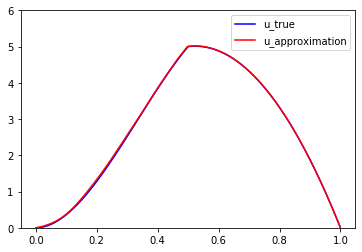

In [120]:
plt.plot(points, yt, color = 'b', label = 'u_true')
plt.plot(points, ymu, color = 'r', label = 'u_approximation')
plt.ylim([0,6])
plt.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


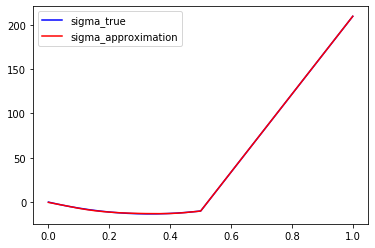

In [121]:
plt.plot(points, y_diff, color = 'b', label = 'sigma_true')
plt.plot(points, ysig, color = 'r', label = 'sigma_approximation')
plt.legend()

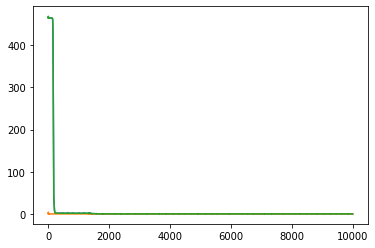

In [21]:
num = np.arange(1, len(loss_bulk_record)+1, 1)
plt.plot(num, loss_bulk_record)
plt.plot(num, loss_surf_record)
plt.plot(num, np.add(loss_bulk_record , loss_surf_record))